# Libraries

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import os, pathlib, glob, math, random
import warnings

from sklearn.metrics import mean_squared_error, mean_absolute_error,  r2_score, mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

from kerashypetune import KerasBayesianSearch
from hyperopt import hp, Trials

from sklearn.preprocessing import MinMaxScaler,StandardScaler
import scienceplots


sns.set_context("paper")

# Data Loading

In [2]:
data_dir = "PB/"
data_dir = pathlib.Path(data_dir)
folder = list(data_dir.glob('*'))
print('Folder Structure:')
for f in folder:
    print(f)

Folder Structure:
PB\Precio_Bolsa_Nacional_($kwh)_2018.xlsx
PB\Precio_Bolsa_Nacional_($kwh)_2019.xlsx
PB\Precio_Bolsa_Nacional_($kwh)_2020.xlsx
PB\Precio_Bolsa_Nacional_($kwh)_2021.xlsx
PB\Precio_Bolsa_Nacional_($kwh)_2022.xlsx


In [3]:
datosPB = pd.DataFrame()
for f in sorted(glob.glob(str(data_dir)+"/*.xlsx")):
  df = pd.read_excel(f, engine='openpyxl', header=2)
  datosPB = pd.concat([datosPB,df], axis=0, sort=False, ignore_index=True)
datosPB = datosPB.dropna(axis=1)
datosPB = datosPB.drop(labels=['Fecha'],axis=1)
datosPB = pd.DataFrame({"Electricity_Bid_Price":datosPB.stack().reset_index(drop=True)})
rng = pd.date_range(start = '2018-01-01 00:00', end ='2022-12-31 23:00', freq='h')
datosPB = datosPB.set_index(rng)
print(datosPB.shape)
datosPB.head(5)

(43824, 1)


,Electricity_Bid_Price
2018-01-01 00:00:00,123.167294
2018-01-01 01:00:00,123.167294
2018-01-01 02:00:00,123.167294
2018-01-01 03:00:00,123.167294
2018-01-01 04:00:00,123.167294


# Data Pre-processing

In [4]:
datosPB = np.log(datosPB + 1)

## Train-test Splitting

In [5]:
fin_train = '2021-12-31 23:00:00'
inicio_prueba = '2022-01-01 00:00:00'

datosPB_train = datosPB.loc[: fin_train, :]
datosPB_test = datosPB.loc[inicio_prueba:, :]

train_size = datosPB_train.shape[0]
test_size = datosPB_test.shape[0]

print(f"Fechas train      : {datosPB_train.index.min()} --- {datosPB_train.index.max()}")
print(f"Fechas test       : {datosPB_test.index.min()} --- {datosPB_test.index.max()}")

Fechas train      : 2018-01-01 00:00:00 --- 2021-12-31 23:00:00
Fechas test       : 2022-01-01 00:00:00 --- 2022-12-31 23:00:00


## Data Scaling

In [6]:
LSTMscaler = MinMaxScaler(feature_range=(-1, 1))
LSTMscaler = LSTMscaler.fit(datosPB_train)
datosPB_train_LSTM = LSTMscaler.transform(datosPB_train)
datosPB_test_LSTM = LSTMscaler.transform(datosPB_test)

## Data LSTM Formatting

In [7]:
time_lags = 48
f_window = 8

In [8]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
   n_vars = 1 if type(data) is list else data.shape[1]
   df = pd.DataFrame(data)
   cols, names = list(), list()
   # input sequence (t-n, ... t-1)
   for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
   # forecast sequence (t, t+1, ... t+n)
   for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
      agg.dropna(inplace=True)
   return agg

In [9]:
data_train, data_test = series_to_supervised(datosPB_train_LSTM, time_lags, f_window), series_to_supervised(datosPB_test_LSTM, time_lags, f_window)
data_train.shape, data_test.shape

((35009, 56), (8705, 56))

In [10]:
X_train_LSTM, X_test_LSTM = data_train.values[:, 0:time_lags], data_test.values[:, 0:time_lags]
y_train_LSTM, y_test_LSTM = data_train.values[:, time_lags:], data_test.values[:, time_lags:]
print(X_train_LSTM.shape,  X_test_LSTM.shape, y_train_LSTM.shape, y_test_LSTM.shape)
X_train_LSTM, X_test_LSTM= X_train_LSTM.reshape(X_train_LSTM.shape[0], X_train_LSTM.shape[1], 1), X_test_LSTM.reshape(X_test_LSTM.shape[0], X_test_LSTM.shape[1], 1)
print(X_train_LSTM.shape,  X_test_LSTM.shape, y_train_LSTM.shape, y_test_LSTM.shape)


(35009, 48) (8705, 48) (35009, 8) (8705, 8)
(35009, 48, 1) (8705, 48, 1) (35009, 8) (8705, 8)


# Model Building

### T2V-LSTM

In [11]:
class T2V(Layer):

  def __init__(self, output_dim=None, **kwargs):
    self.output_dim = output_dim
    super(T2V, self).__init__(**kwargs)

  def build(self, input_shape):
    self.W = self.add_weight(name='W',
                             shape=(input_shape[-1], self.output_dim),
                             initializer='uniform',
                             trainable=True)

    self.P = self.add_weight(name='P',
                             shape=(input_shape[1], self.output_dim),
                             initializer='uniform',
                             trainable=True)

    self.w = self.add_weight(name='w',
                             shape=(input_shape[1], 1),
                             initializer='uniform',
                             trainable=True)

    self.p = self.add_weight(name='p',
                             shape=(input_shape[1], 1),
                             initializer='uniform',
                             trainable=True)

    super(T2V, self).build(input_shape)

  def call(self, x):
    original = self.w * x + self.p
    sin_trans = K.sin(K.dot(x, self.W) + self.P)
    return K.concatenate([sin_trans, original], -1)

In [12]:
def set_seed(seed):
  tf.random.set_seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  random.seed(seed)

def T2V_LSTM(param, dim):
  set_seed(33)
  inp = Input(shape=(dim,1))
  x = T2V(param['t2v_dim'])(inp)
  x = Concatenate(axis=-1)([inp, x])
  x = LSTM(param['unit_1'], activation=param['act'], return_sequences=True)(x)
  x = Dropout(0.1)(x)
  x = LSTM(param['unit_2'], activation=param['act'], return_sequences=True)(x)
  x = Dropout(0.1)(x)
  x = LSTM(param['unit_3'], activation=param['act'])(x)
  x = Dropout(0.1)(x)
  #x = Flatten()(x)
  x = Dense(8, activation='linear')(x)
  m = Model(inp, x)
  m.compile(loss='mse',optimizer=Adam(learning_rate=param['lr']))
  return m

In [13]:
param_grid = {
    'unit_1': 64 + hp.randint('unit_1', 64),
    'unit_2': 64 + hp.randint('unit_2', 64),
    'unit_3': 64 + hp.randint('unit_3', 64),
    't2v_dim': 64 + hp.randint('t2v_dim', 64),
    'lr': 1e-3,
    'act': 'tanh',
    'epochs': 200,
    'batch_size': 128
}

In [15]:
callbacksLSTM = [EarlyStopping(patience=10, monitor='val_loss', mode='auto', restore_best_weights=True),\
                 ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose = 1, factor = 0.8, min_lr = 1e-5),\
                 CSVLogger('Train_Data.csv', separator=',', append=True)]

hypermodel = lambda x: T2V_LSTM(param=x, dim=time_lags)

kgs_t2v = KerasBayesianSearch(hypermodel, param_grid, monitor='val_loss',
                              greater_is_better=False, tuner_verbose=1,
                              n_iter=16, sampling_seed=33)
kgs_t2v.search(X_train_LSTM, y_train_LSTM, trials=Trials(), validation_split=0.2, callbacks=[callbacksLSTM], shuffle=True)


16 trials detected for ('unit_1', 'unit_2', 'unit_3', 't2v_dim', 'lr', 'act', 'epochs', 'batch_size')

***** (1/16) *****
Search({'act': 'tanh', 'batch_size': 128, 'epochs': 200, 'lr': 0.001, 't2v_dim': 120, 'unit_1': 122, 'unit_2': 122, 'unit_3': 90})

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005120000336319208.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00040960004553198815.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.00032768002711236477.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002621440216898918.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.00020971521735191345.

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.00016777217388153076.

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.00013421773910522462.

Epoch 25: ReduceLROnPlateau reducing learn

In [16]:
kgs_t2v.best_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 48, 1)]      0           []                               
                                                                                                  
 t2v_2 (T2V)                    (None, 48, 92)       4555        ['input_3[0][0]']                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 48, 93)       0           ['input_3[0][0]',                
                                                                  't2v_2[0][0]']                  
                                                                                                  
 lstm_6 (LSTM)                  (None, 48, 119)      101388      ['concatenate_2[0][0]']    

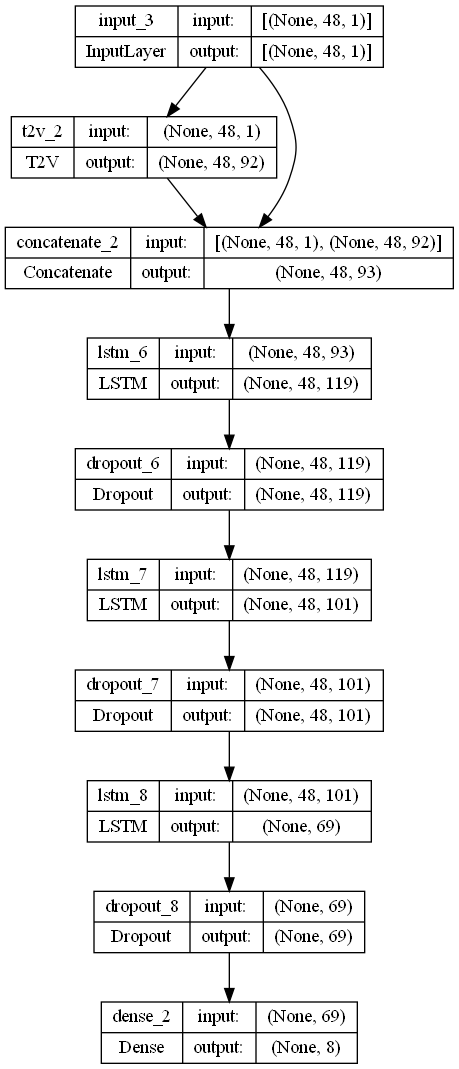

In [17]:
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(kgs_t2v.best_model, to_file=dot_img_file, show_shapes=True)

In [18]:
tuning_history = pd.read_csv("Train_Data.csv",header=0).reset_index(drop=True)
indices = tuning_history.loc[tuning_history['epoch'] == 0].index

hist_dataframes = []
for i, index in enumerate(indices):
  if i == len(indices) - 1:
    hist_dataframes.append(tuning_history.loc[index:])
  else:
    hist_dataframes.append(tuning_history.loc[index:indices[i+1]-1])

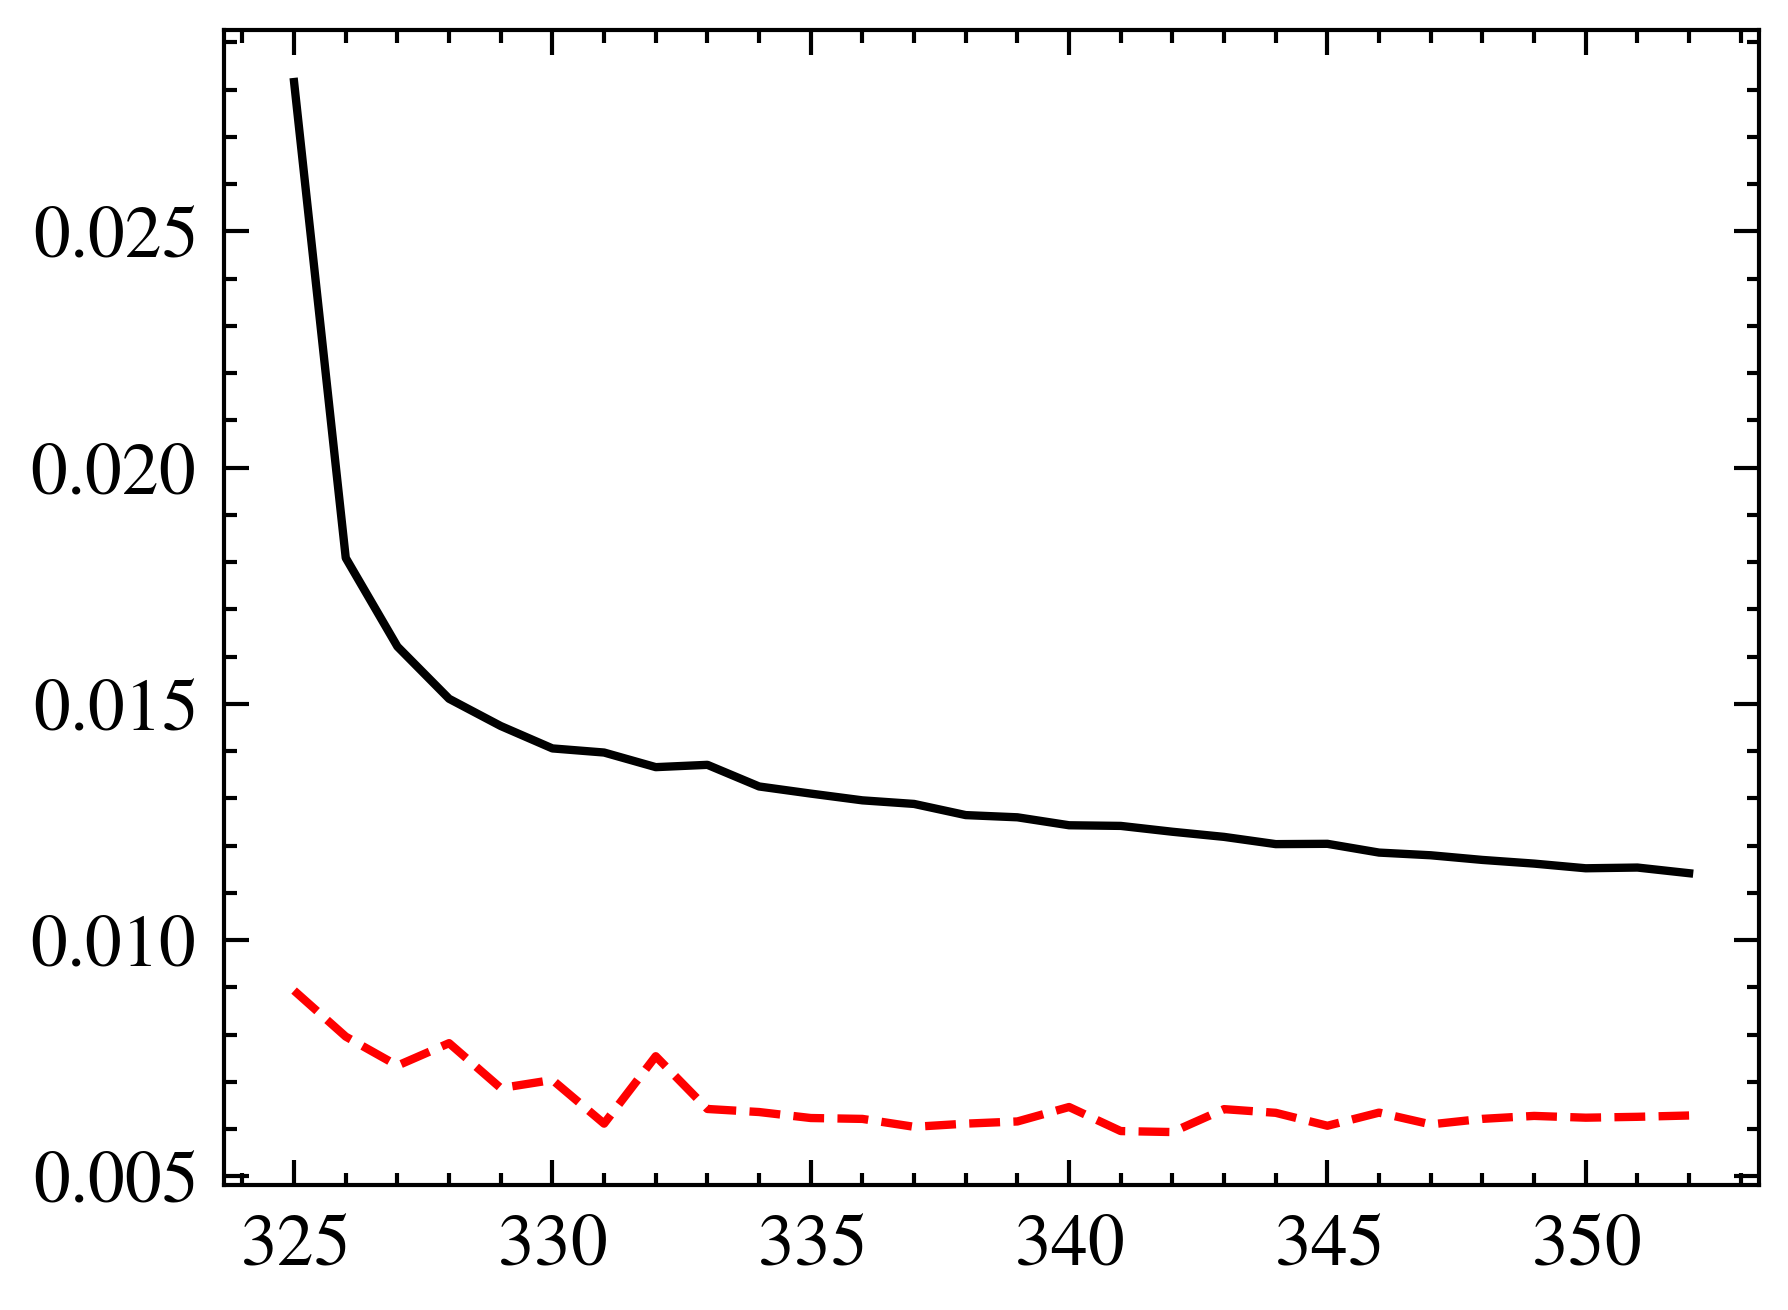

In [21]:
with plt.style.context(['science','ieee','no-latex']):
  plt.figure()
  plt.plot(hist_dataframes[13]['loss'])
  plt.plot(hist_dataframes[13]['val_loss'])
  plt.show()

# Forecasting

In [22]:
#pred_t2v = LSTMscaler.inverse_transform(kgs_t2v.best_model.predict(X_test_LSTM))
pred_t2v = np.e**(LSTMscaler.inverse_transform(kgs_t2v.best_model.predict(X_test_LSTM))) - 1
#real_data = LSTMscaler.inverse_transform(y_test_LSTM)
real_data = np.e**(LSTMscaler.inverse_transform(y_test_LSTM)) - 1
print("MSE:", mean_squared_error(real_data, pred_t2v))
print("RMSE:", math.sqrt(mean_squared_error(real_data, pred_t2v)))
print("MAE:", mean_absolute_error(real_data, pred_t2v))
print("MAPE:", mean_absolute_percentage_error(real_data, pred_t2v)*100)
print("R2:", r2_score(real_data, pred_t2v))

273/273 [==============================] - 3s 9ms/step
MSE: 1668.2841363375223
RMSE: 40.844634119275966
MAE: 19.626922375209404
MAPE: 8.436997197063251
R2: 0.896598513797837


In [23]:
Classic = pd.read_csv("Forecasting_Results/datos_Pred_CM.csv",header=None)
XGB = pd.read_csv('Forecasting_Results/Results_XGB.csv',header=None)
MLP = pd.read_csv('Forecasting_Results/Results_MLP.csv',header=None)

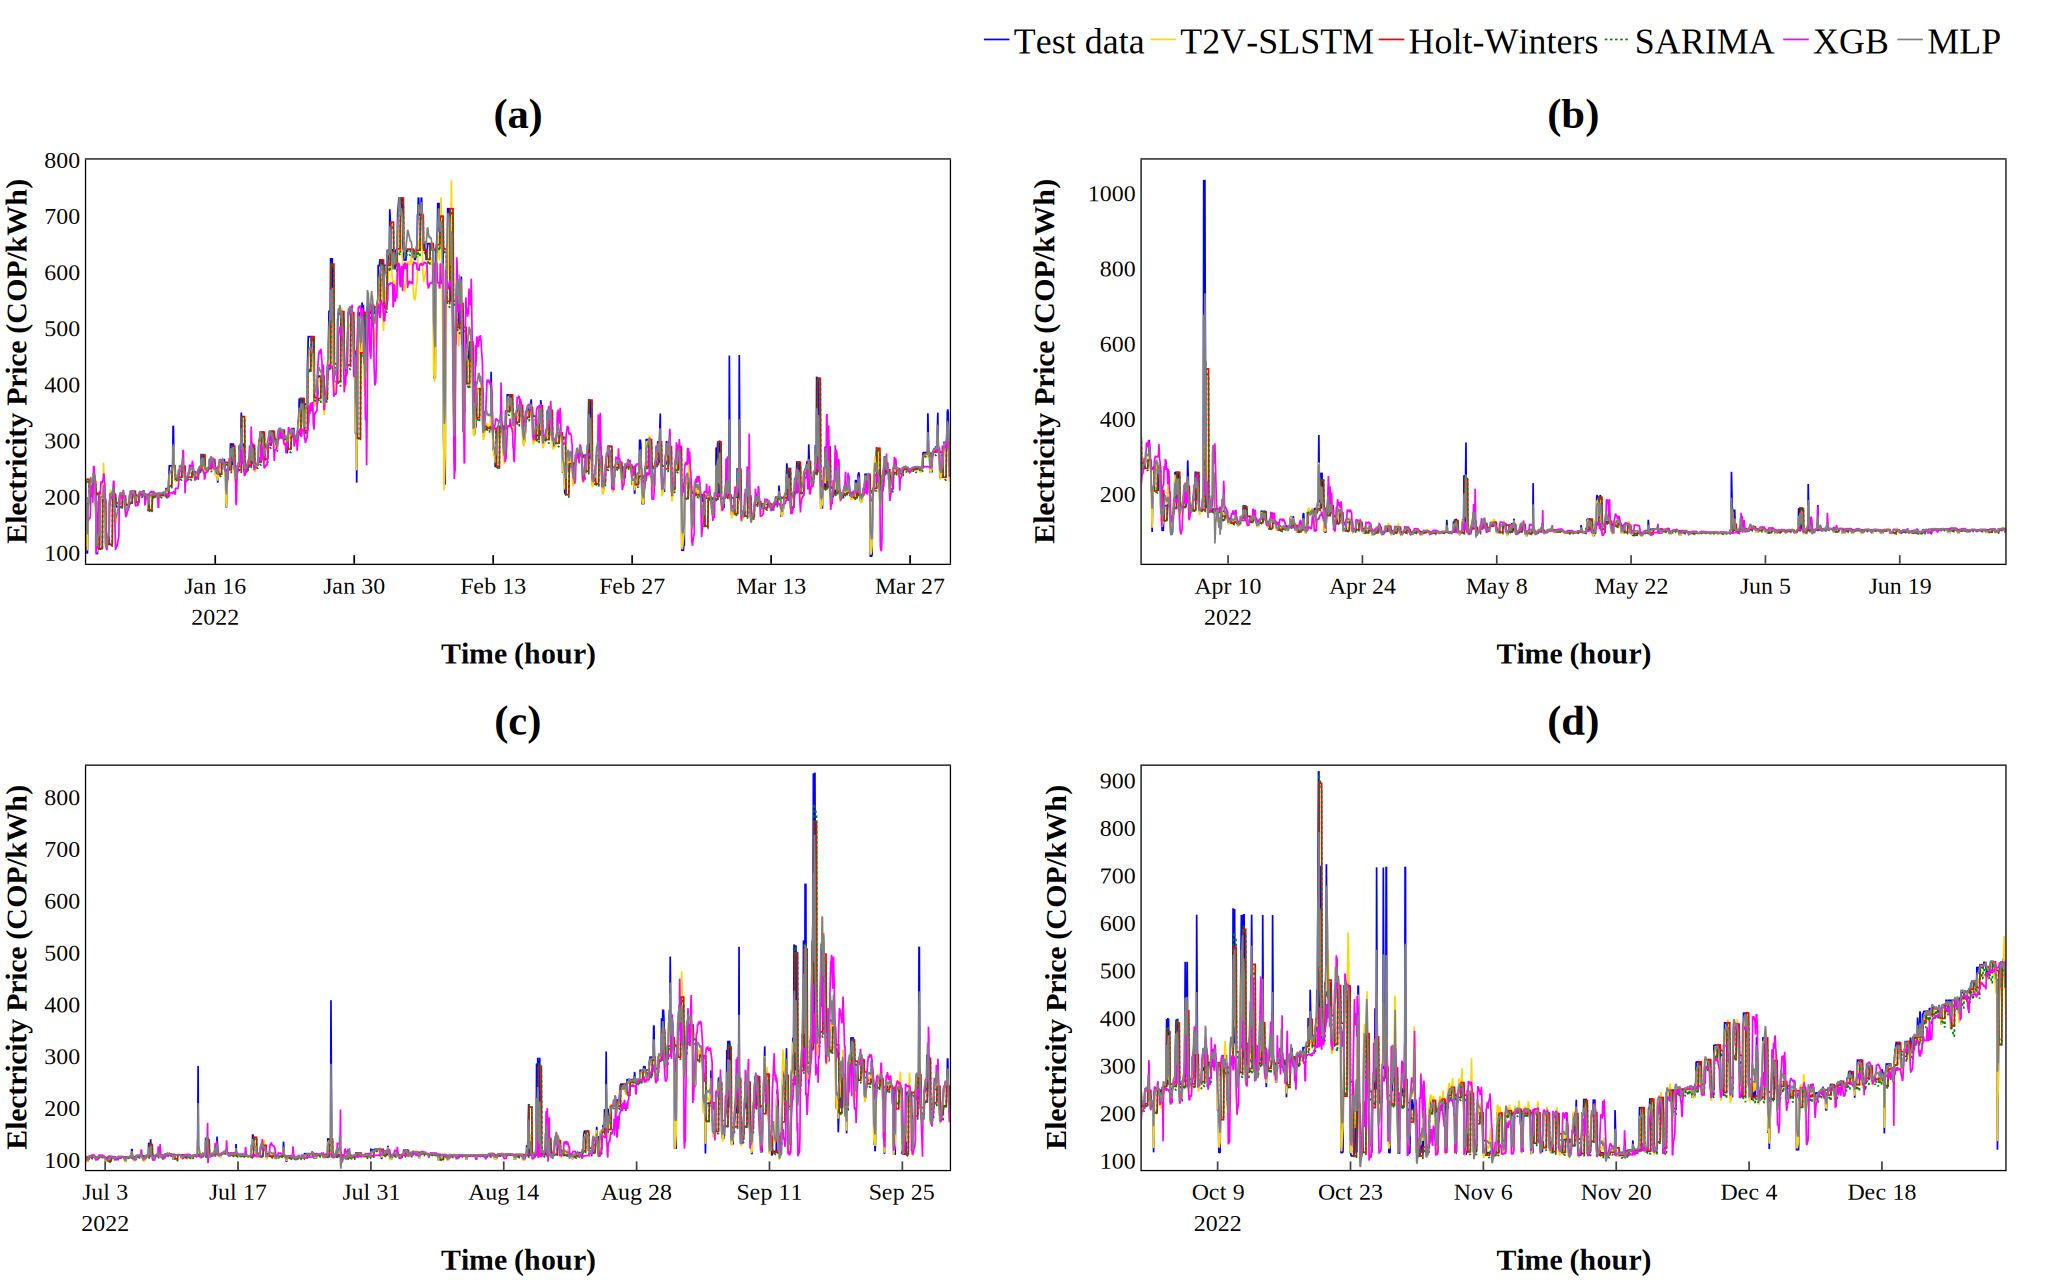

In [35]:
figPBCom = make_subplots(rows=2, cols=2, subplot_titles = ['<b>(a)</b>','<b>(b)</b>','<b>(c)</b>','<b>(d)</b>'],
                         vertical_spacing=0.2)


figPBCom.append_trace(go.Scatter(y=np.e**(datosPB_test.Electricity_Bid_Price[time_lags-1:,])-1, x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="blue"),
                                 name="Test data", stackgaps='infer zero'), row=1, col=1)
figPBCom.append_trace(go.Scatter(y=pred_t2v[:,0], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="gold"),
                                 name="T2V-SLSTM", stackgaps='infer zero'), row=1, col=1)
figPBCom.append_trace(go.Scatter(y=Classic[time_lags-1:][0], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="red"),
                                 name="Holt-Winters", stackgaps='infer zero'), row=1, col=1)
figPBCom.append_trace(go.Scatter(y=Classic[time_lags-1:][1], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="green", dash='dot'),
                                 name="SARIMA", stackgaps='infer zero'), row=1, col=1)
figPBCom.append_trace(go.Scatter(y=XGB.values[:,8], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="magenta"),
                                 name="XGB", stackgaps='infer zero'), row=1, col=1)
figPBCom.append_trace(go.Scatter(y=MLP.values[:,0], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="gray"),
                                 name="MLP", stackgaps='infer zero'), row=1, col=1)


figPBCom.append_trace(go.Scatter(y=np.e**(datosPB_test.Electricity_Bid_Price[time_lags-1:,])-1, x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="blue"),
                                 name="Test data", showlegend=False), row=2, col=1)
figPBCom.append_trace(go.Scatter(y=pred_t2v[:,0], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="gold"),
                                 name="Stacked-LSTM", showlegend=False), row=2, col=1)
figPBCom.append_trace(go.Scatter(y=Classic[time_lags-1:][0], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="red"),
                                 name="Holt-Winters", showlegend=False), row=2, col=1)
figPBCom.append_trace(go.Scatter(y=Classic[time_lags-1:][1], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="green", dash='dot'),
                                 name="SARIMA", showlegend=False), row=2, col=1)
figPBCom.append_trace(go.Scatter(y=XGB.values[:,8], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="magenta"),
                                 name="XGB", showlegend=False, stackgaps='infer zero'), row=2, col=1)
figPBCom.append_trace(go.Scatter(y=MLP.values[:,0], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="gray"),
                                 name="MLP", showlegend=False, stackgaps='infer zero'), row=2, col=1)



figPBCom.append_trace(go.Scatter(y=np.e**(datosPB_test.Electricity_Bid_Price[time_lags-1:,])-1, x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="blue"),
                                 name="Test data", showlegend=False), row=1, col=2)
figPBCom.append_trace(go.Scatter(y=pred_t2v[:,0], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="gold"),
                                 name="Stacked-LSTM", showlegend=False), row=1, col=2)
figPBCom.append_trace(go.Scatter(y=Classic[time_lags-1:][0], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="red"),
                                 name="Holt-Winters", showlegend=False), row=1, col=2)
figPBCom.append_trace(go.Scatter(y=Classic[time_lags-1:][1], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="green", dash='dot'),
                                 name="SARIMA", showlegend=False), row=1, col=2)
figPBCom.append_trace(go.Scatter(y=XGB.values[:,8], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="magenta"),
                                 name="XGB", showlegend=False, stackgaps='infer zero'), row=1, col=2)
figPBCom.append_trace(go.Scatter(y=MLP.values[:,0], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="gray"),
                                 name="MLP", showlegend=False, stackgaps='infer zero'), row=1, col=2)


figPBCom.append_trace(go.Scatter(y=np.e**(datosPB_test.Electricity_Bid_Price[time_lags-1:,])-1, x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="blue"),
                                 name="Test data", showlegend=False), row=2, col=2)
figPBCom.append_trace(go.Scatter(y=pred_t2v[:,0], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="gold"),
                                 name="Stacked-LSTM", showlegend=False), row=2, col=2)
figPBCom.append_trace(go.Scatter(y=Classic[time_lags-1:][0], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="red"),
                                 name="Holt-Winters", showlegend=False), row=2, col=2)
figPBCom.append_trace(go.Scatter(y=Classic[time_lags-1:][1], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="green", dash='dot'),
                                 name="SARIMA", showlegend=False), row=2, col=2)
figPBCom.append_trace(go.Scatter(y=XGB.values[:,8], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="magenta"),
                                 name="XGB", showlegend=False, stackgaps='infer zero'), row=2, col=2)
figPBCom.append_trace(go.Scatter(y=MLP.values[:,0], x=datosPB_test.index[time_lags-1:],
                                 mode='lines', line=dict(width=2, color="gray"),
                                 name="MLP", showlegend=False, stackgaps='infer zero'), row=2, col=2)


figPBCom.update_layout(title='',
                      #paper_bgcolor='rgba(0,0,0,0)',
                      plot_bgcolor='rgba(0,0,0,0)',
                      width=2400,height=1500,
                      yaxis=dict(color="black"),
                      xaxis=dict(color="black"),
                      margin=dict(l=50,r=50,b=120,t=120),
                      font=dict(family="Times New Roman", color='black'),
                      legend=dict(orientation="h",yanchor="bottom",y=1.09,xanchor="right",x=1, font_size=42, font_color='black'),
                      showlegend=True)

figPBCom.update_xaxes(range=['2022-01-03 00:00:00','2022-03-31 00:00:00'], row=1,col=1)
figPBCom.update_xaxes(range=['2022-04-01 00:00:00','2022-06-30 00:00:00'], row=1,col=2)
figPBCom.update_xaxes(range=['2022-07-01 00:00:00','2022-09-30 00:00:00'], row=2,col=1)
figPBCom.update_xaxes(range=['2022-10-01 00:00:00','2022-12-31 00:00:00'], row=2,col=2)


figPBCom.update_yaxes(range=[80,800], row=1,col=1)
figPBCom.update_yaxes(range=[80,860], row=2,col=1)
figPBCom.update_yaxes(range=[80,930], row=2,col=2)

figPBCom.update_xaxes(showline=True, linewidth=1.5, ticks='inside',ticklen=10, tickwidth=2, linecolor='black', gridcolor=None, mirror=True, title_text='<b>Time (hour)</b>', titlefont_size=35, tickfont_size=28)
figPBCom.update_yaxes(showline=True, linewidth=1.5, gridcolor=None, linecolor='black', mirror=True, title_text='<b>Electricity Price (COP/kWh)</b>', titlefont_size=35, tickfont_size=28)
figPBCom.update_traces(connectgaps=False)
figPBCom.update_annotations(font=dict(size=50))
figPBCom.layout.annotations[0].update(y=1.02)
figPBCom.layout.annotations[1].update(y=1.02)
figPBCom.layout.annotations[2].update(y=0.42)
figPBCom.layout.annotations[3].update(y=0.42)
figPBCom.show("svg")